# *Bandwidth Selection Analysis*
Exploring the impact of bandwidth on treatment effect estimates to find optimal model bandwidth.

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/My Drive/CustomerDataset.xlsx')

Mounted at /content/drive


In [ ]:
from google.colab import files

uploaded = files.upload()
df = pd.read_excel('Customer Purchase DataSet.xlsx')

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import levene
import numpy as np
import matplotlib.pyplot as plt

# Add binary boolean treatment indictor at $80
df['Treatment'] = (df['Dollars Spent 2021'] >= 80).astype(int)

# Define independent and dependent variables according to initial model specifications
df['Interaction'] = df['Dollars Spent 2021'] * df['Treatment']
X = df[['Dollars Spent 2021', 'Treatment', 'Interaction']]
X = sm.add_constant(X)
y = df['Dollars Spent 2022']


model = sm.OLS(df['Dollars Spent 2022'], X).fit()

In [ ]:
# List to store R-squared values, treatment effects, confidence intervals, P-value of Levene tests, and data set sizes
r_squared = []
treatment_effects = []
ci_lower = []
ci_upper = []
levene_pvalues = []
data_size = []

# Range of bandwidths covered
start = 5
end = 175
inc = 1

# Loop to test badwidths. start -> end in inc intervals
for bandwidth in range(start, end, inc):

  # Filter 2021 spending data based on current bandwidth
  filtered_df = df[(df['Dollars Spent 2021'] >= 80 - bandwidth) & (df['Dollars Spent 2021'] <= 80 + bandwidth)]

  # Define variables
  filtered_df.loc[:, 'Interaction'] = filtered_df['Dollars Spent 2021'] * filtered_df['Treatment']
  X = filtered_df[['Dollars Spent 2021', 'Treatment', 'Interaction']]
  X = sm.add_constant(X)
  y = filtered_df['Dollars Spent 2022']

  # Fit the model with data selection
  model = sm.OLS(y, X).fit()


  # Extract model treatment effect and append to list
  treatment_effects.append(model.params['Treatment'])

  # Extract confidence intervals and append to list
  conf_int = model.conf_int().loc['Treatment']
  ci_lower.append(conf_int[0])
  ci_upper.append(conf_int[1])

  # Extract residuals split into treated and untreated
  residuals = model.resid
  treated_residuals = residuals[filtered_df['Treatment'] == 1]
  untreated_residuals = residuals[filtered_df['Treatment'] == 0]
  # Extract P-value of Levene tests and append to list
  p_value = levene(treated_residuals, untreated_residuals)[1]
  levene_pvalues.append(p_value)

  # Extract R-squared value and append to list
  r_squared.append(model.rsquared)

  # Extract data set size and append to list
  data_size.append(model.nobs)


# Convert the results to a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Bandwidth': range(start, end, inc),
    'R_Squared': r_squared,
    'Treatment_Effect': treatment_effects,
    'CI_Lower': ci_lower,
    'CI_Upper': ci_upper,
    'Levene_P-Values': levene_pvalues,
    'Data_Size': data_size
})
results_df.head()

,Bandwidth,R_Squared,Treatment_Effect,CI_Lower,CI_Upper,Levene_P-Values,Data_Size
0,5,0.232194,10.478956,-60.939216,81.897127,0.140657,898.0
1,6,0.242781,13.830445,-41.018682,68.679572,0.165060,1081.0
2,7,0.302120,17.240848,-25.786377,60.268074,0.300654,1273.0
3,8,0.345620,4.562582,-31.152452,40.277616,0.633174,1459.0
4,9,0.377829,11.184226,-18.979972,41.348425,0.481605,1638.0


## *Complete Range Analysis*

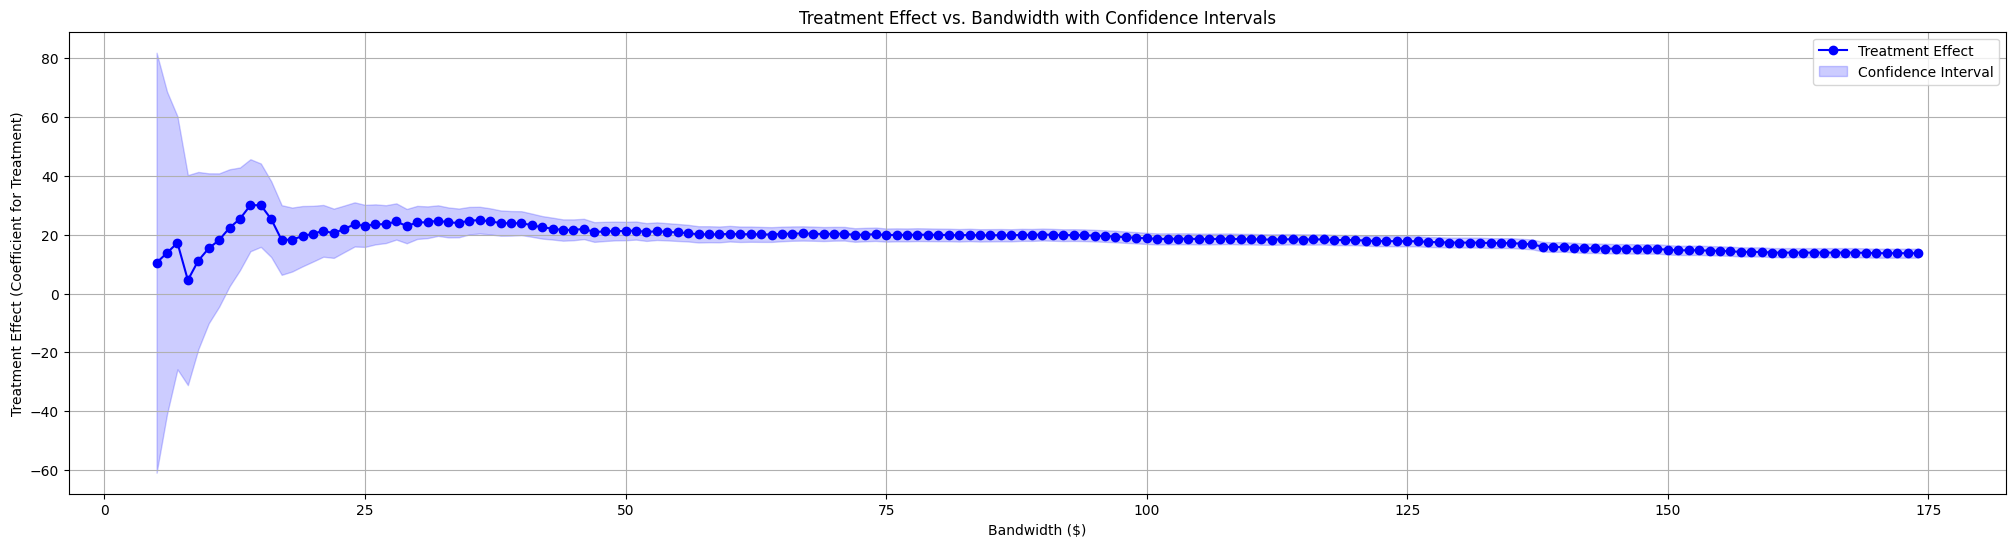

In [ ]:
# Plotting the treatment effect vs. bandwidth, complete range of data colected ($5 - $200)
plt.figure(figsize=(25, 6))
plt.plot(results_df['Bandwidth'], results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
plt.fill_between(results_df['Bandwidth'], results_df['CI_Lower'], results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Treatment Effect (Coefficient for Treatment)')
plt.title('Treatment Effect vs. Bandwidth with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   Confidence intercals are initially wide and fluctuating at low bandwidths (5 - 15), narrows greatly
*   Treatment seems to stabalizes around 15-20
*   a slight bell-shaped curve between 25 and 45 can be observed

**Takeaway**: We see the condifance interval narrow while effect stays relitivly stable going well into the 30s-40s, and have minimal change after passing 50. Let's look around 50.

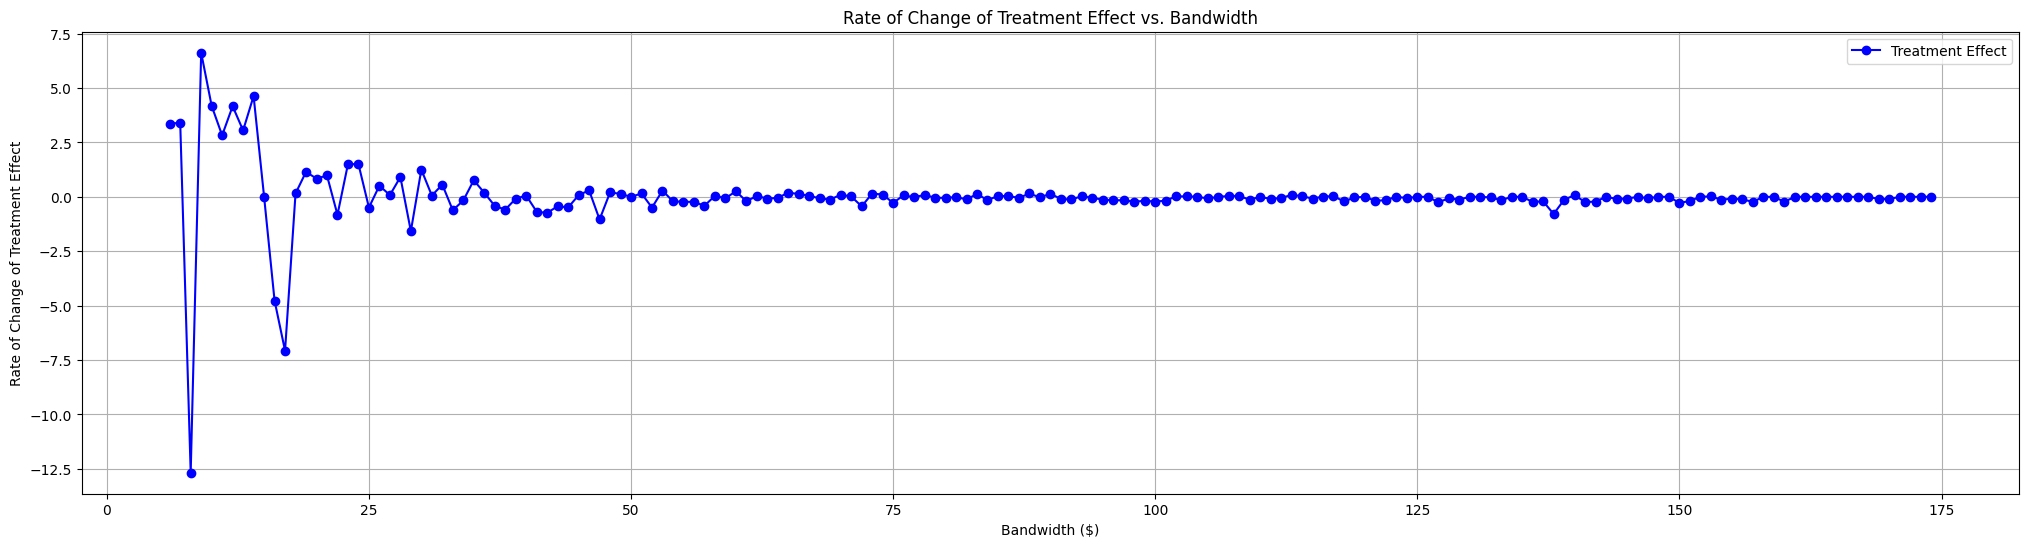

In [ ]:
# Calculate the rate of change (derivative) of the treatment effect, using diff()
plt.figure(figsize=(25, 6))
plt.plot(results_df['Bandwidth'], results_df['Treatment_Effect'].diff(), label='Treatment Effect', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Rate of Change of Treatment Effect')
plt.title('Rate of Change of Treatment Effect vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   Clearly presents where the treatment stabilizes (when bandwidths get closer to 0 ROC)
*   ROC fluctuates in lower ranges up until 30s
*   Acheives greater (close to 0 ROC) stability around mid 30s
*   ROC in treatment effect stays close to 0 for higher bandwidths (50 - 175)

**Takeaway**: Reinforces that treatment begins stabalizes around 15-20, increasingly stable in the 30s. Avoid values under 30s.  

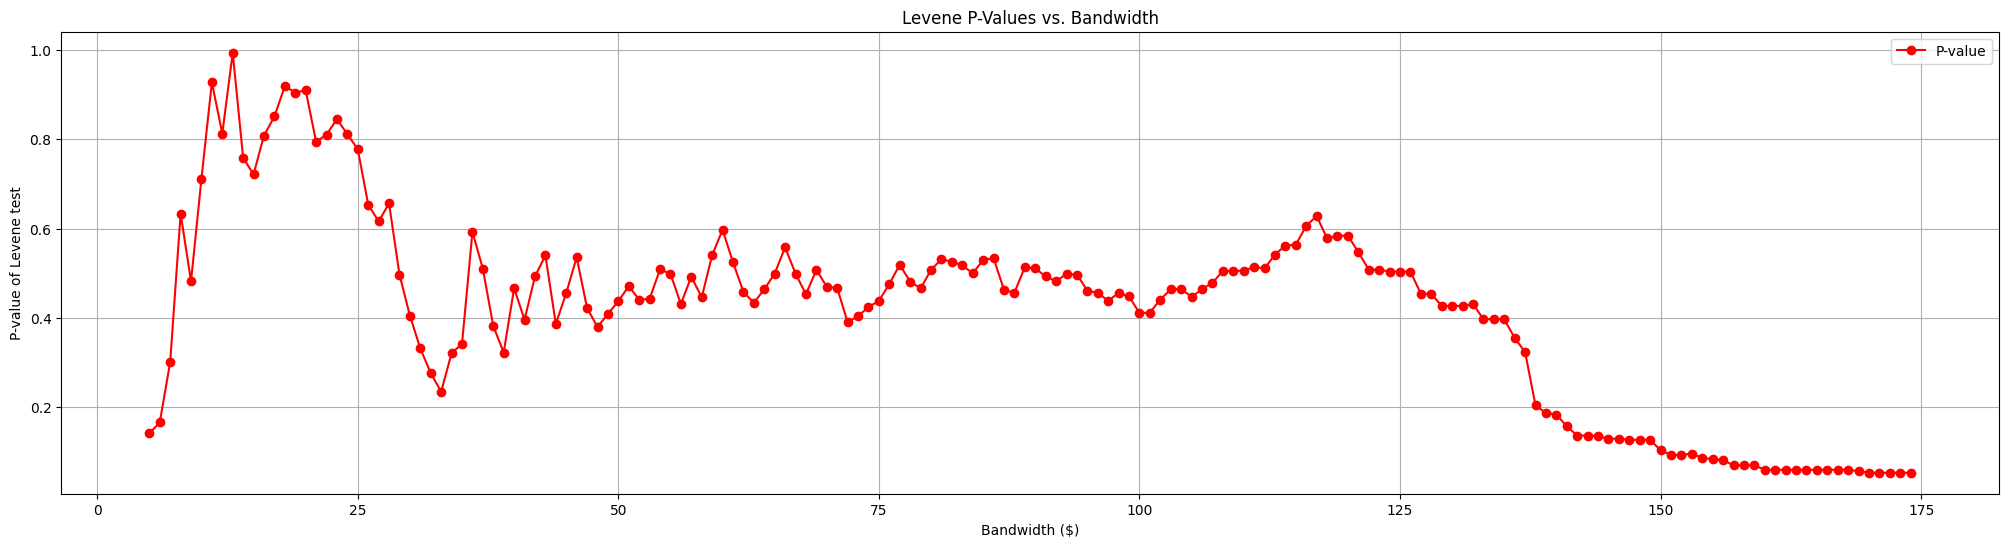

In [ ]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(25, 6))
plt.plot(results_df['Bandwidth'], results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.xlabel('Bandwidth ($)')
plt.ylabel('P-value of Levene test')
plt.title('Levene P-Values vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   Ideal P-values across majority of the plot (5 - 125)
*   Large dip around 135

**Takeaway**: We don't have to worry about P-values until the super high ranges (125 and up) when the P-value begins to drops very low

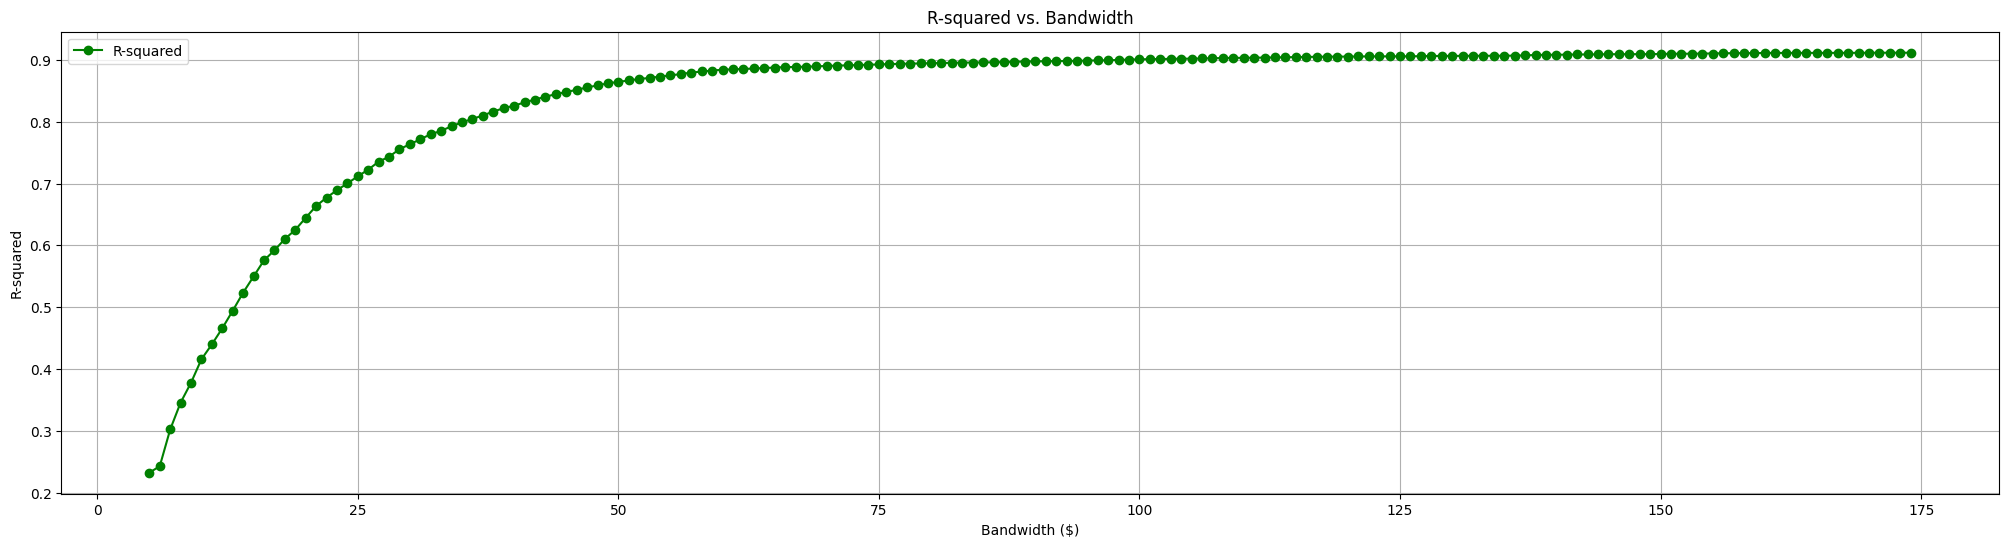

In [ ]:
# Plotting the r-squared vs. bandwidth, complete range of data colected ($5 - $200)
plt.figure(figsize=(25, 6))
plt.plot(results_df['Bandwidth'], results_df['R_Squared'], label='R-squared', marker='o', color='g')
plt.xlabel('Bandwidth ($)')
plt.ylabel('R-squared')
plt.title('R-squared vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   Low and greatly increasing at lower bandwidths
*   Begins stabilizing in the 40s-50s
*   Maintains around a 0.9 r-squared value continuing into higher ranges

**Takeaway**: Further reinforces the push away from lower bandwidths due to low r-squared values. Points to look after the 40s-50s.

## *10-70 Bandwidth Analysis*


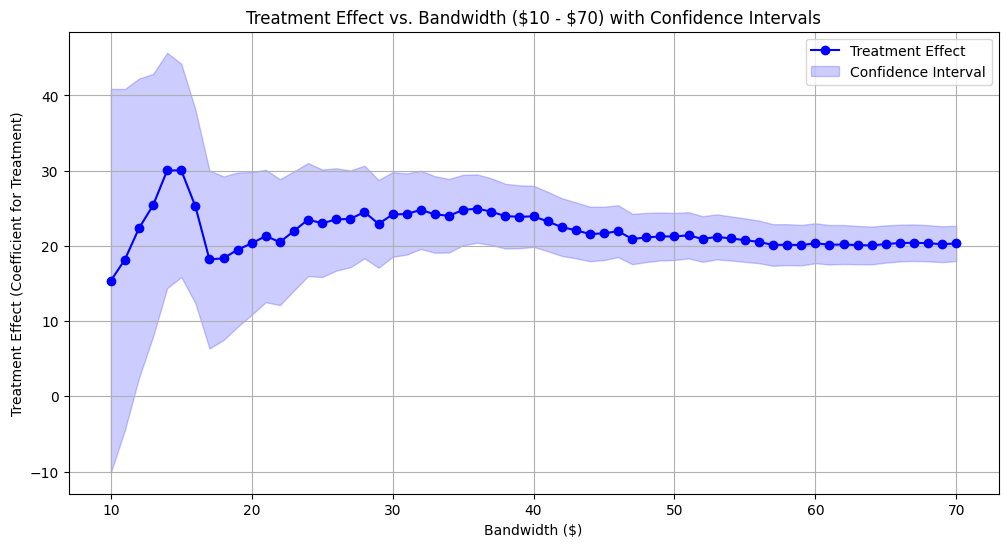

In [ ]:
# Slice the existing DataFrame to focus on the smaller range ($25 to $45)
start = 10
end = 70
# inc = 2

partial_results_df = results_df[(results_df['Bandwidth'] >= start) & (results_df['Bandwidth'] <= end)]
# partial_results_df = partial_results_df[partial_results_df['Bandwidth'] % inc == 0]

# Plotting the treatment effect vs. bandwidth, partial range of data colected ($5 - $55)
plt.figure(figsize=(12, 6))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
plt.fill_between(partial_results_df['Bandwidth'], partial_results_df['CI_Lower'], partial_results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Treatment Effect (Coefficient for Treatment)')
plt.title('Treatment Effect vs. Bandwidth (\$10 - \$70) with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   Clear view of a bell-shaped curve between 25 and 45
*   Beyond 25-45, the treatment effect stabilizes, and the confidence intervals narrow

**Takeaway**: Higher bandwidths in this range are preferable with narrower confidence interval.

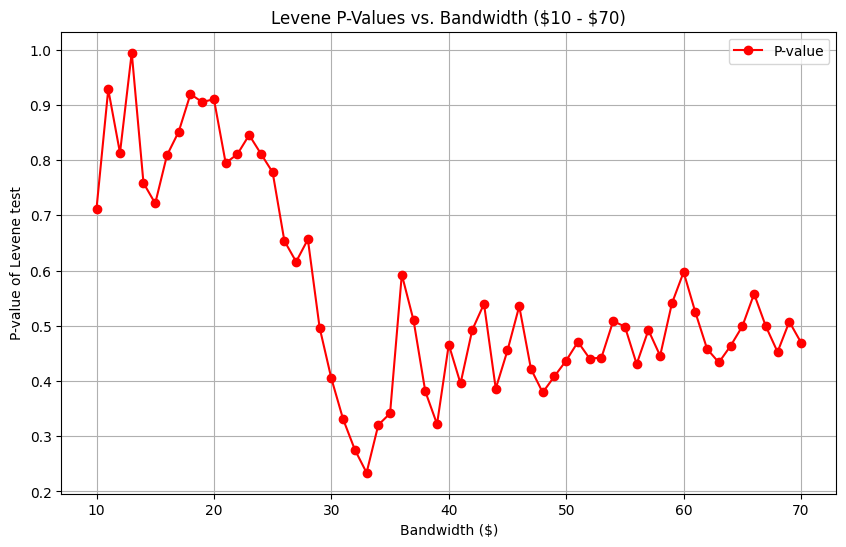

In [ ]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(10, 6))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.xlabel('Bandwidth ($)')
plt.ylabel('P-value of Levene test')
plt.title('Levene P-Values vs. Bandwidth (\$10 - \$70)')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   The p-values have great variablity in lower bandwidths until about 35.
*   Peaks in p-value throughout 30s.

**Takeaway**: Higher bandwidths in this range are preferable with less variablility in P-values


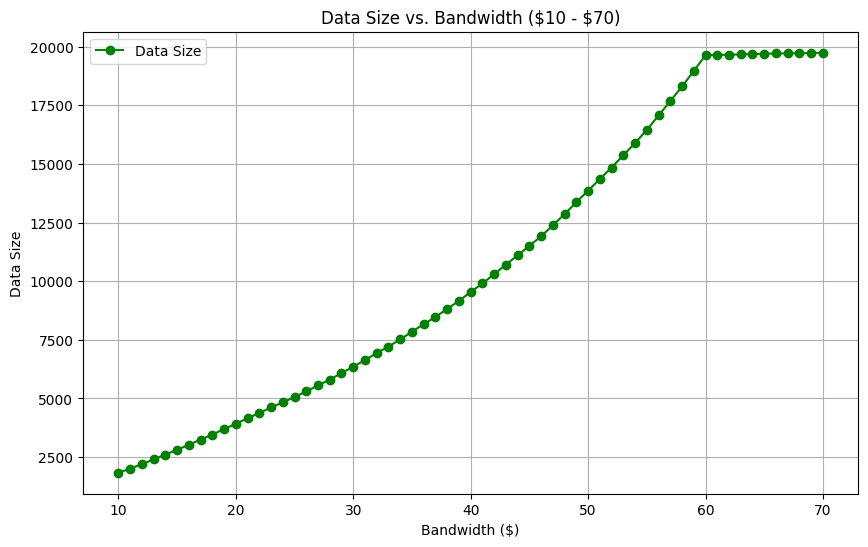

In [ ]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(10, 6))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Data_Size'], label='Data Size', marker='o', color='g')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Data Size')
plt.title('Data Size vs. Bandwidth (\$10 - \$70)')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   Data size steadily increases as bandwidth increases

**Takeaway**: Reinforces push for higher bandwidths, to be able to work with more data points.

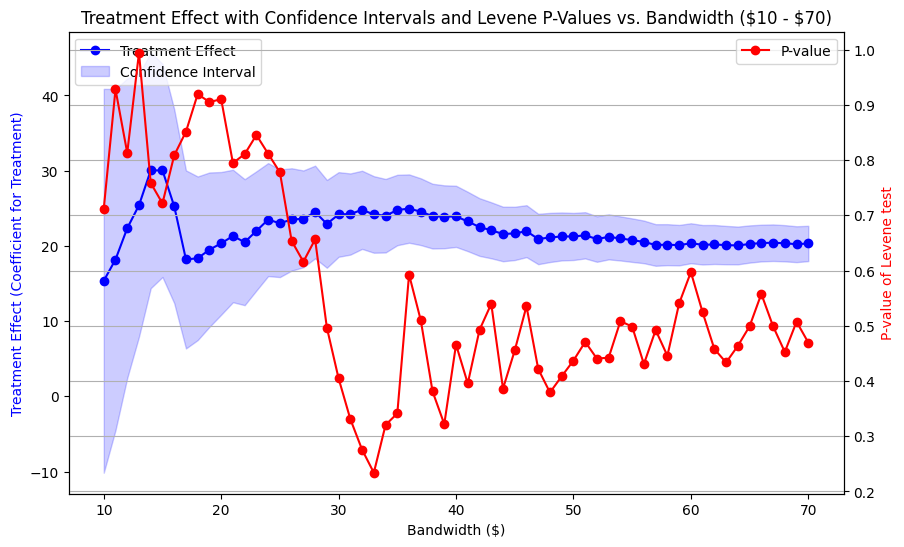

In [ ]:
# Plotting the treatment effect & p-value of Levene tests vs. bandwidth

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Bandwidth ($)')

# Plotting treatment effect with CI intervals on the left y-axis
ax1.set_ylabel('Treatment Effect (Coefficient for Treatment)', color='b')
ax1.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
ax1.fill_between(partial_results_df['Bandwidth'], partial_results_df['CI_Lower'], partial_results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.legend(loc='upper left')

# Plotting the p-value of Levene tests on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('P-value of Levene test', color='r')
ax2.plot(partial_results_df['Bandwidth'], partial_results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.legend()

plt.title('Treatment Effect with Confidence Intervals and Levene P-Values vs. Bandwidth (\$10 - \$70)')
plt.grid(True)
plt.show()

## *Bandwidth Conclusion*
The analysis of the treatment effect, confidence intervals, rate of change, Levene's p-values, and data size collectively point to $35 as the optimal bandwidth. At \$35, there is a balance between bias and variance. This bandwidth ensures that the estimates are robust and not overly influenced by outliers or noise while maintaining a substantial sample size.


## *Additional Bandwidth Analysis*
Viewing data in various ways, seeking sharp changes or a significant shift in the effect to identify points of inflection.

### Treatment Effect Cumulative Sum Plot

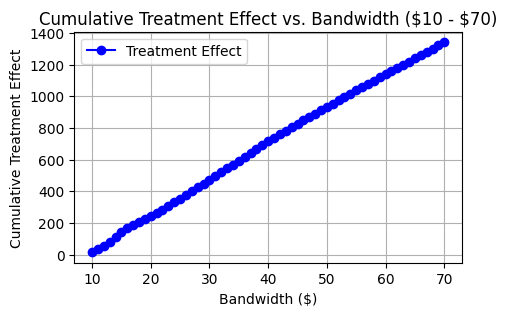

In [ ]:
# Plotting the cumulative sum of the treatment effect
plt.figure(figsize=(5, 3))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'].cumsum(), label='Treatment Effect', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Cumulative Treatment Effect')
plt.title('Cumulative Treatment Effect vs. Bandwidth (\$10 - \$70)')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   No important analysis/takeaways.

### Treatment Effect Rate of Change Plot

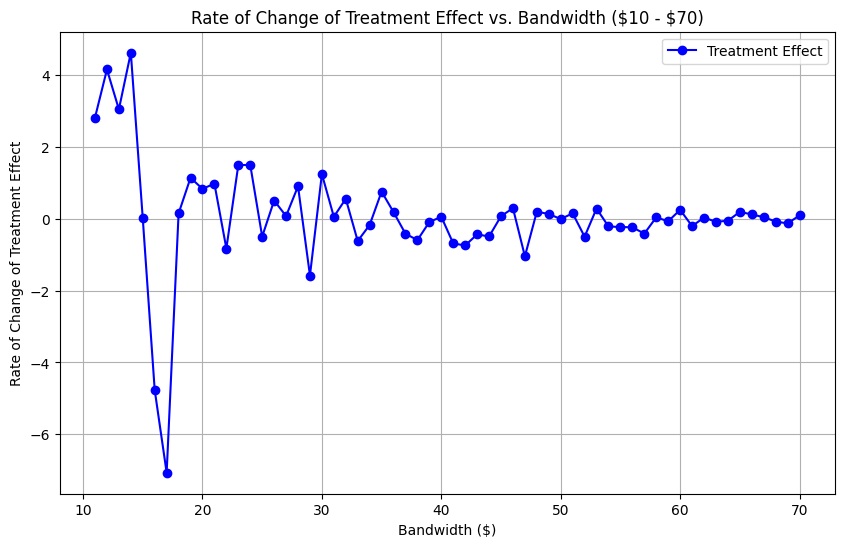

In [ ]:
# Calculate the rate of change (derivative) of the treatment effect
plt.figure(figsize=(10, 6))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'].diff(), label='Treatment Effect', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Rate of Change of Treatment Effect')
plt.title('Rate of Change of Treatment Effect vs. Bandwidth (\$10 - \$70)')
plt.legend()
plt.grid(True)
plt.show()


###Plot Analysis:

*   The plot reveals a point where the treatment effect changes rapidly, indicating an inflection range where the bandwidth starts to stabilize.
*   After 50, ROC stays close to 0.

**Takeaway**: We can use this analysis to further prove stability of treatment effect after/in the 50s.

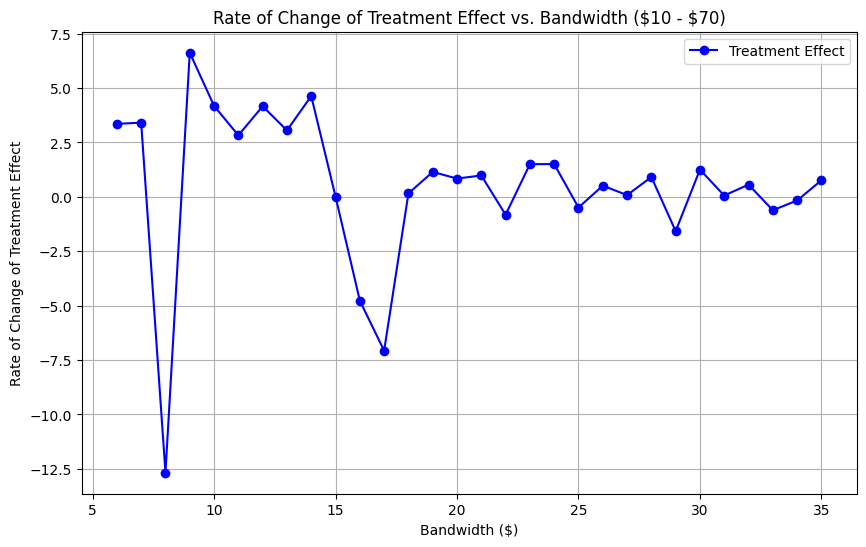

In [ ]:
# Closer look at where the rate of change stabalizes
ROC_results_df = results_df[(results_df['Bandwidth'] >= 5) & (results_df['Bandwidth'] <= 35)]

plt.figure(figsize=(10, 6))
plt.plot(ROC_results_df['Bandwidth'], ROC_results_df['Treatment_Effect'].diff(), label='Treatment Effect', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Rate of Change of Treatment Effect')
plt.title('Rate of Change of Treatment Effect vs. Bandwidth (\$10 - \$70)')
plt.legend()
plt.grid(True)
plt.show()

###Plot Analysis:
*   No important analysis/takeaways.